In [1]:
using JLD
using MotivatingExamples
using PGFPlots

In [2]:
# store results for all runs in a nested dictionary
# top-level key = experiment name 
# middle-level key = run iteration
# bottom-level key = information of interest
results = Dict();

In [3]:
function update_results(r::Dict, trainer::Trainer, learner::Learner, env::Env, policy::Policy, 
        topkey::String, midkey::Int, adaptive::Bool, n_steps::Int)
    m = trainer.monitor
    
    # add the topkey if not already added
    if !in(topkey, keys(r))
        r[topkey] = Dict()
        r[topkey]["adaptive"] = adaptive
        r[topkey]["n_steps"] = n_steps
    end
    r[topkey][midkey] = Dict()
    r[topkey][midkey]["learning_curve"] = m.info["state-value rmse loss"][:]
    state_values = predict(learner, m.eval_states)
    r[topkey][midkey]["state_values"] = state_values
    r[topkey][midkey]["final_loss"] = rmse(m.v_true, state_values)
end

function aggregate_results_across_runs(r::Dict)
    aggregate_results = Dict()
    for (experiment_name, runs) in r
        mean_final_loss = 0
        state_values = zeros(size(runs[1]["state_values"]))
        
        min_learning_curve_length = typemax(Int)
        for (run, _) in runs
            if typeof(run) == Int
                min_learning_curve_length = min(length(runs[run]["learning_curve"]), min_learning_curve_length)
            end
        end
        learning_curve = zeros(min_learning_curve_length)
        run_count = 0
        for (run, run_results) in runs
            if typeof(run) == Int
                run_count += 1
                mean_final_loss += run_results["final_loss"]
                state_values .+= run_results["state_values"]
                learning_curve .+= run_results["learning_curve"][1:min_learning_curve_length]
            end
        end
        aggregate_results[experiment_name] = Dict()
        aggregate_results[experiment_name]["final_loss"] = mean_final_loss ./ run_count
        aggregate_results[experiment_name]["state_values"] = state_values ./ run_count
        aggregate_results[experiment_name]["learning_curve"] = learning_curve ./ run_count
        aggregate_results[experiment_name]["adaptive"] = runs["adaptive"]
        aggregate_results[experiment_name]["n_steps"] = runs["n_steps"]
    end
    return aggregate_results
end

aggregate_results_across_runs (generic function with 1 method)

In [4]:
# 1D, shared settings, objects

# env 
env = Continuous1DRandomWalkEnv(xmin = -100, xmax = 100)

# policy
policy = UnivariateGaussianPolicy()

# learner settings
nbins = 40 # number of bins at which to linearly interpolate
bins = linspace(env.xmin, env.xmax, nbins)
target_dim = 1 # output dim of learner
lr = .1
discount = .999

# evaluation
n_runs = 5
n_eval_bins = 100
eval_states = reshape(linspace(env.xmin, env.xmax, n_eval_bins), (1, n_eval_bins))
m = 1. / (env.xmax - env.xmin)
b = env.xmin
v_true = reshape(eval_states, 1, n_eval_bins) .* m .+ .5

# training settings 
run_eval_every = 5000 # how frequently to check performance
budget = typemax(Float64) # training is based on steps not real time
max_step_count = 50000
update_dist_freq = 5000 # only applies if actually adaptive
util_temp = .1 # softmax temp for utilities only applies if actually adaptive
timer = BudgetTimer(budget) # will be reset each run
monitor = TrainingMonitor(timer = timer, eval_states = eval_states, # will also be reset for each training call
        v_true = v_true, run_eval_every = run_eval_every);

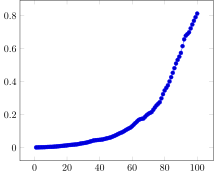

In [5]:
# get true values if necessary
if discount != 1.
    learner = MCLearner(RectangleGrid(bins), target_dim, discount = discount, lr = lr)
    true_trainer_step_count = max_step_count * 10
    trainer = AdaptiveTrainer(
                nothing,
                monitor,
                max_episode_steps = 5, # n-step MC / TD
                num_mc_runs = 1,
                max_step_count = true_trainer_step_count,
                update_dist_freq = -1,
                util_temp = util_temp
        )
    reinitialize(learner)
    reinitialize(trainer)
    train(trainer, learner, env, policy)
    v_true = predict(learner, collect(eval_states))
    monitor.v_true = v_true
    Plots.Linear(collect(1:length(v_true)), reshape(v_true, length(v_true))) 
end

In [6]:
# 1D, TD(0)
for adaptive in [false, true]
    learner = TDLearner(RectangleGrid(bins), target_dim, discount = discount, lr = lr)
    trainer = AdaptiveTrainer(
            nothing,
            monitor,
            max_episode_steps = 1,
            num_mc_runs = 1,
            max_step_count = max_step_count,
            update_dist_freq = adaptive ? update_dist_freq : -1,
            util_temp = util_temp
    )
    exp_name = adaptive ? "TD(0) Adaptive" : "TD(0)"
    for run in 1:n_runs
        reinitialize(learner)
        reinitialize(trainer)
        train(trainer, learner, env, policy)
        update_results(results, trainer, learner, env, policy, exp_name, run, adaptive, 1)
    end
end

In [7]:
# 1D, N-step MC / TD
for adaptive in [false, true]
    for n_steps in [50, 500]
        learner = MCLearner(RectangleGrid(bins), target_dim, discount = discount, lr = lr)
        trainer = AdaptiveTrainer(
                nothing,
                monitor,
                max_episode_steps = n_steps, # n-step MC / TD
                num_mc_runs = 1,
                max_step_count = max_step_count,
                update_dist_freq = adaptive ? update_dist_freq : -1,
                util_temp = util_temp
        )
        exp_name = adaptive ? "$(n_steps)-Step TD Adaptive" : "$(n_steps)-Step TD"
        for run in 1:n_runs
            reinitialize(learner)
            reinitialize(trainer)
            train(trainer, learner, env, policy)
            update_results(results, trainer, learner, env, policy, exp_name, run, adaptive, n_steps)
        end
    end
end

In [8]:
# aggregate results
agg_results = aggregate_results_across_runs(results);

In [9]:
# save results
JLD.save("../data/run_results.jld", "results", results);
JLD.save("../data/agg_results.jld", "agg_results", agg_results);

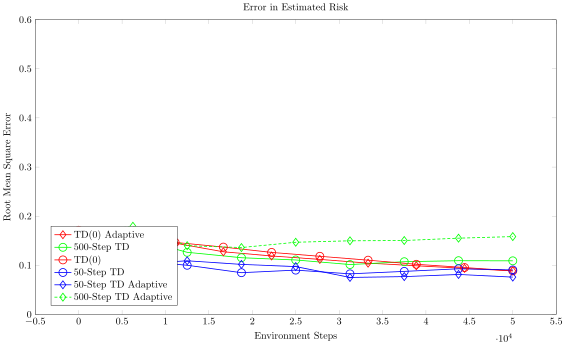

In [10]:
# visualize learning curves
# g = GroupPlot(t_max_nbins, mc_nbins, groupStyle = "horizontal sep = 1.5cm, vertical sep = 1.4cm")
a = Axis(legendPos="south west", width="20cm", height="12cm", xlabel="Environment Steps", ylabel="Root Mean Square Error", 
title="Error in Estimated Risk", ymin=0., ymax=.6)
markcolors = Dict(1=>"red", 50=>"blue", 500=>"green")
for (i, (exp_name, exp_results)) in enumerate(agg_results)
    curve = exp_results["learning_curve"]
    timesteps = linspace(0, max_step_count, length(curve))
    marker = exp_results["adaptive"] ? "diamond" : "o"
    markcolor = markcolors[exp_results["n_steps"]]
    marker = contains(exp_name, "Adaptive") ? "diamond" : "o"
    p = Plots.Linear(timesteps, curve, 
        legendentry="$(exp_name)",
        mark=marker,
        style="$(markcolor),thick",
        markSize=4)
    push!(a, p)
end
PGFPlots.save("../data/results/motivating_learning_curve.pdf", a)
a

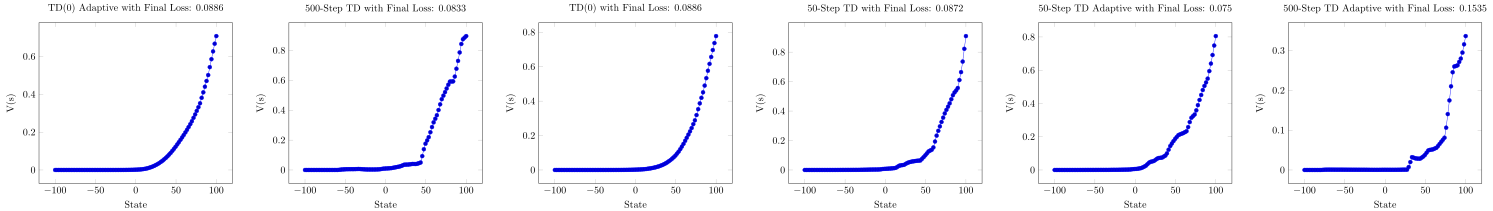

In [11]:
# plot all the value functions
g = GroupPlot(2, 2, groupStyle = "horizontal sep = 2cm, vertical sep = 2cm")
markcolors = ["red", "blue", "green", "black"]
for (i, (exp_name, exp_results)) in enumerate(agg_results)
    states = collect(reshape(eval_states, length(exp_results["state_values"])))
    state_values = reshape(exp_results["state_values"], length(exp_results["state_values"]))
    final_loss = round(exp_results["final_loss"], 4)
    p = Axis(Plots.Linear(states, state_values), 
        title="$(exp_name) with Final Loss: $(final_loss)",
        xlabel="State",
        ylabel="V(s)")
    push!(g, p)
end
PGFPlots.save("../data/results/motivating_state_values.pdf", g)
g